# Srilanka Dengue Outbreak Forecasting using Darts

## Environment Setup

In [1]:
!pip install darts
!pip install dask[dataframe]
!pip install statsmodels

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Imports

In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from darts import TimeSeries

%matplotlib inline

In [4]:
df = pd.read_csv("/content/drive/MyDrive/Datasets/Sri_Lanka_Dengue_Cases_and_Weather_Data_updated.csv")

## 2. Load Dataset

In [5]:
df.head()

,District,Number_of_Cases,Week_Start_Date,Year,Month,Week,Week_End_Date,Avg Max Temp (°C),Avg Min Temp (°C),Avg Apparent Max Temp (°C),Avg Apparent Min Temp (°C),Total Precipitation (mm),Avg Wind Speed (km/h),Max Wind Gusts (km/h),Avg Daylight Duration (hours)
0,Ampara,0,2007-01-01,2007,1,1,2007-01-08,26.9375,21.8625,28.8500,24.1000,8.0,18.2000,44.3,11.714583
1,Ampara,0,2007-01-08,2007,1,2,2007-01-15,26.3500,23.3250,30.2625,26.7000,86.1,17.0250,43.6,11.733333
2,Ampara,0,2007-01-15,2007,1,3,2007-01-22,27.2125,23.1625,29.5750,25.9625,3.1,20.1875,48.2,11.754167
3,Ampara,0,2007-01-22,2007,1,4,2007-01-29,26.7250,23.0375,29.9500,26.1125,53.6,17.2000,42.5,11.783333
4,Ampara,0,2007-01-29,2007,1,5,2007-02-05,27.3625,22.9625,30.7500,26.1250,8.2,17.2625,40.0,11.812500


In [6]:
len(df)

23250

In [7]:
districts = df['District'].unique()
districts

array(['Ampara', 'Anuradhapura', 'Badulla', 'Batticaloa', 'Colombo',
       'Galle', 'Gampaha', 'Hambantota', 'Jaffna', 'Kalutara', 'Kandy',
       'Kegalle', 'Kilinochchi', 'Kurunegala', 'Mannar', 'Matale',
       'Matara', 'Monaragala', 'Mullaitivu', 'NuwaraEliya', 'Polonnaruwa',
       'Puttalam', 'Ratnapura', 'Trincomalee', 'Vavuniya'], dtype=object)

## 3. Small Visualization

In [8]:
# Check Duplicate values
duplicates = df[['District', 'Week_Start_Date', 'Week_End_Date']].duplicated().any()
if duplicates:
    print("There are duplicate values.")
else:
    print("No duplicates found.")

No duplicates found.


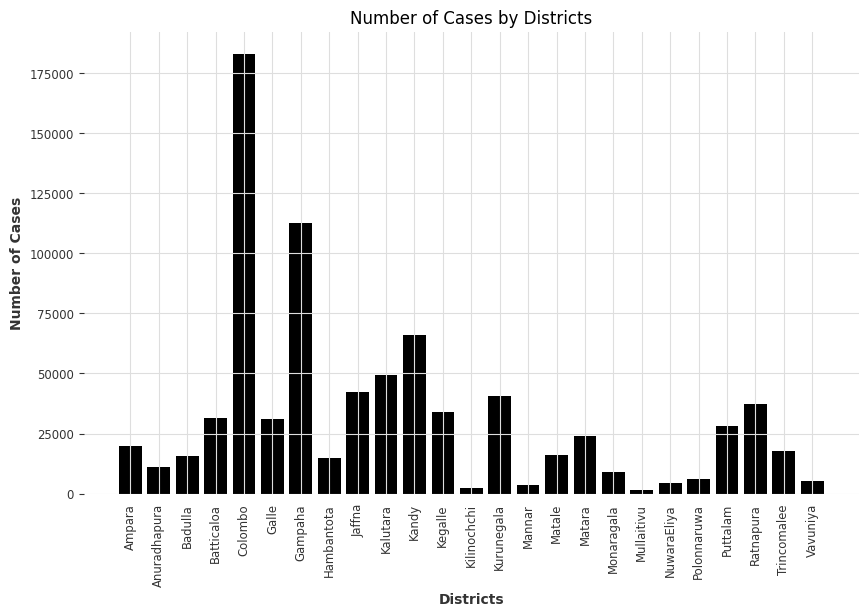

In [9]:
# Group by District and sum the Number of Cases
district_cases = df.groupby('District')['Number_of_Cases'].sum().reset_index()

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.bar(district_cases['District'], district_cases['Number_of_Cases'])
plt.xlabel('Districts')
plt.ylabel('Number of Cases')
plt.title('Number of Cases by Districts')
plt.xticks(rotation=90)
plt.show()


## 4. Minor pre-processing
1. Only taking single timestamp for each row. Either `Week_Start_Date` or `Week_Start_Date`. We gonna take `Week_End_Date`.
2. Convert the `Week_End_Date` to Python Datetime format.
3. Eliminate un-used features such as `Week_Start_Date`, `Month`, `Year`, and `Week`

In [10]:
df['Week_End_Date'] = pd.to_datetime(df['Week_End_Date'])

In [11]:
df.head()

,District,Number_of_Cases,Week_Start_Date,Year,Month,Week,Week_End_Date,Avg Max Temp (°C),Avg Min Temp (°C),Avg Apparent Max Temp (°C),Avg Apparent Min Temp (°C),Total Precipitation (mm),Avg Wind Speed (km/h),Max Wind Gusts (km/h),Avg Daylight Duration (hours)
0,Ampara,0,2007-01-01,2007,1,1,2007-01-08,26.9375,21.8625,28.8500,24.1000,8.0,18.2000,44.3,11.714583
1,Ampara,0,2007-01-08,2007,1,2,2007-01-15,26.3500,23.3250,30.2625,26.7000,86.1,17.0250,43.6,11.733333
2,Ampara,0,2007-01-15,2007,1,3,2007-01-22,27.2125,23.1625,29.5750,25.9625,3.1,20.1875,48.2,11.754167
3,Ampara,0,2007-01-22,2007,1,4,2007-01-29,26.7250,23.0375,29.9500,26.1125,53.6,17.2000,42.5,11.783333
4,Ampara,0,2007-01-29,2007,1,5,2007-02-05,27.3625,22.9625,30.7500,26.1250,8.2,17.2625,40.0,11.812500


## 5. Modelling
List of regression models.
- RegressionModel
- LinearRegressionModel
- RandomForest
- LightGBMModel
- XGBModel
- CatBoostModel



In [12]:
from darts.models import RegressionModel, RandomForest, LinearRegressionModel, XGBModel, LightGBMModel, CatBoostModel
from sklearn.linear_model import Ridge
from darts.metrics import rmse, mae, smape, rmsle

In [13]:
!pip install "u8darts[all]"

In [14]:
reg = RegressionModel(
    lags=[-1, -2, -3, -13, -26, -52],
    lags_future_covariates=[-1, -2, -3, -13, -26, -52],
    model = Ridge(),
    output_chunk_length=12,  # Number of time steps predicted at once (per chunk) by the internal model.
)
lr  = LinearRegressionModel(
    lags=[-1, -2, -3, -13, -26, -52],
    lags_future_covariates=[-1, -2, -3, -13, -26, -52],
    output_chunk_length=12, # Number of time steps predicted at once (per chunk) by the internal model.
    random_state=42
)

rf = RandomForest(
    lags=[-1, -2, -3, -13, -26, -52, -104],
    lags_future_covariates=[-1, -2, -3, -13, -26, -52],
    output_chunk_length=12, # Number of time steps predicted at once (per chunk) by the internal model.
    random_state=42
)

lgbm = LightGBMModel(
    lags=[-1, -2, -3, -13, -26, -52, -104],
    lags_future_covariates=[-1, -2, -3, -13, -26, -52],
    output_chunk_length=12, # Number of time steps predicted at once (per chunk) by the internal model.
    random_state=42
)
xgb = XGBModel(
    lags=[-1, -2, -3, -13, -26, -52, -104],
    lags_future_covariates=[-1, -2, -3, -13, -26, -52],
    output_chunk_length=12, # Number of time steps predicted at once (per chunk) by the internal model.
    random_state=42
)
cat = CatBoostModel(
    lags=[-1, -2, -3, -13, -26, -52, -104],
    lags_future_covariates=[-1, -2, -3, -13, -26, -52],
    output_chunk_length=12, # Number of time steps predicted at once (per chunk) by the internal model.
    random_state=42
)

In [15]:
models = [reg, lr, rf, lgbm, xgb, cat]

In [16]:
def train_and_forecast(train_series, val_series, future_covariates, model, district_name):
    model.fit(train_series, future_covariates=future_covariates)

    # Forecast for the next 12 weeks
    forecast = model.predict(n=len(val_series), future_covariates=future_covariates)

    # Calculate metrics
    val_values = val_series.values()
    forecast_values = forecast.values()

    # Ensure the forecast and validation values are the same length
    assert len(val_values) == len(forecast_values), "Forecast and validation series must have the same length for metrics calculation."

    # Compute metrics
    error_rmse = rmse(val_series, forecast)
    error_mae = mae(val_series, forecast)
    error_smape = smape(val_series, forecast)
    error_rmsle = rmsle(val_series, forecast)

    errors = {
        "RMSE": error_rmse,
        "MAE": error_mae,
        "SMAPE": error_smape,
        "RMSLE": error_rmsle
    }
    results = [forecast, errors]
    return results

In [17]:
def main(data, models):
    districts = data['District'].unique()
    final_output = []
    for district in districts:
      # Filter data for the specified district
      district_data = data[data['District'] == district]

      # Ensure the 'Week_End_Date' column is in datetime format
      district_data['Week_End_Date'] = pd.to_datetime(district_data['Week_End_Date'])

      # Prepare the data for ARIMA
      series = TimeSeries.from_dataframe(district_data, time_col='Week_End_Date', value_cols=['Number_of_Cases', 'Avg Max Temp (°C)', "Avg Min Temp (°C)", "Avg Apparent Max Temp (°C)", "Avg Apparent Min Temp (°C)", "Total Precipitation (mm)", "Avg Daylight Duration (hours)", "Avg Wind Speed (km/h)"])

      # Split series
      # Set aside the last 12 weeks as a validation series
      train_data, val_data = series["Number_of_Cases"][:-12], series["Number_of_Cases"][-12:]
      future_covariates = series[["Avg Max Temp (°C)", "Avg Min Temp (°C)", "Avg Apparent Max Temp (°C)", "Avg Apparent Min Temp (°C)", "Total Precipitation (mm)", "Avg Daylight Duration (hours)", "Avg Wind Speed (km/h)"]]

      print(f"Training length: {len(train_data)}")
      print(f"Validation length: {len(val_data)}")

      district_output = []
      for m in models:
        result = train_and_forecast(train_data, val_data, future_covariates, m, district)
        district_output.append(result)

      final_output.append(district_output)

    return final_output


In [18]:
results = main(df, models)

<ipython-input-17-16d4eef0d2ed>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_data['Week_End_Date'] = pd.to_datetime(district_data['Week_End_Date'])


Training length: 918
Validation length: 12
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10967
[LightGBM] [Info] Number of data points in the train set: 803, number of used features: 49
[LightGBM] [Info] Start training from score 24.158157
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

<ipython-input-17-16d4eef0d2ed>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_data['Week_End_Date'] = pd.to_datetime(district_data['Week_End_Date'])


Training length: 918
Validation length: 12
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000731 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10862
[LightGBM] [Info] Number of data points in the train set: 803, number of used features: 49
[LightGBM] [Info] Start training from score 12.996264
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

<ipython-input-17-16d4eef0d2ed>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_data['Week_End_Date'] = pd.to_datetime(district_data['Week_End_Date'])


Training length: 918
Validation length: 12
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10929
[LightGBM] [Info] Number of data points in the train set: 803, number of used features: 49
[LightGBM] [Info] Start training from score 18.938979
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

<ipython-input-17-16d4eef0d2ed>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_data['Week_End_Date'] = pd.to_datetime(district_data['Week_End_Date'])


Training length: 918
Validation length: 12
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000560 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11200
[LightGBM] [Info] Number of data points in the train set: 803, number of used features: 49
[LightGBM] [Info] Start training from score 38.607721
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

<ipython-input-17-16d4eef0d2ed>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_data['Week_End_Date'] = pd.to_datetime(district_data['Week_End_Date'])


Training length: 918
Validation length: 12
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12231
[LightGBM] [Info] Number of data points in the train set: 803, number of used features: 49
[LightGBM] [Info] Start training from score 217.386052
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

<ipython-input-17-16d4eef0d2ed>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_data['Week_End_Date'] = pd.to_datetime(district_data['Week_End_Date'])
/usr/local/lib/python3.10/dist-packages/darts/metrics/metrics.py:1937: RuntimeWarning: invalid value encountered in log
  y_true, y_pred = np.log(y_true + 1), np.log(y_pred + 1)
/usr/local/lib/python3.10/dist-packages/darts/metrics/metrics.py:1937: RuntimeWarning: invalid value encountered in log
  y_true, y_pred = np.log(y_true + 1), np.log(y_pred + 1)


Training length: 918
Validation length: 12
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11019
[LightGBM] [Info] Number of data points in the train set: 803, number of used features: 49
[LightGBM] [Info] Start training from score 37.540473
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

<ipython-input-17-16d4eef0d2ed>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_data['Week_End_Date'] = pd.to_datetime(district_data['Week_End_Date'])


Training length: 918
Validation length: 12
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12042
[LightGBM] [Info] Number of data points in the train set: 803, number of used features: 49
[LightGBM] [Info] Start training from score 135.127024
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

<ipython-input-17-16d4eef0d2ed>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_data['Week_End_Date'] = pd.to_datetime(district_data['Week_End_Date'])


Training length: 918
Validation length: 12
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000917 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10819
[LightGBM] [Info] Number of data points in the train set: 803, number of used features: 49
[LightGBM] [Info] Start training from score 17.784558
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

<ipython-input-17-16d4eef0d2ed>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_data['Week_End_Date'] = pd.to_datetime(district_data['Week_End_Date'])


Training length: 918
Validation length: 12
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000961 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11258
[LightGBM] [Info] Number of data points in the train set: 803, number of used features: 49
[LightGBM] [Info] Start training from score 52.343711
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

<ipython-input-17-16d4eef0d2ed>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_data['Week_End_Date'] = pd.to_datetime(district_data['Week_End_Date'])


Training length: 918
Validation length: 12
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000640 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11250
[LightGBM] [Info] Number of data points in the train set: 803, number of used features: 49
[LightGBM] [Info] Start training from score 59.100872
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

<ipython-input-17-16d4eef0d2ed>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_data['Week_End_Date'] = pd.to_datetime(district_data['Week_End_Date'])


Training length: 918
Validation length: 12
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11465
[LightGBM] [Info] Number of data points in the train set: 803, number of used features: 49
[LightGBM] [Info] Start training from score 79.201743
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

<ipython-input-17-16d4eef0d2ed>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_data['Week_End_Date'] = pd.to_datetime(district_data['Week_End_Date'])
/usr/local/lib/python3.10/dist-packages/darts/metrics/metrics.py:1937: RuntimeWarning: invalid value encountered in log
  y_true, y_pred = np.log(y_true + 1), np.log(y_pred + 1)


Training length: 918
Validation length: 12
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11154
[LightGBM] [Info] Number of data points in the train set: 803, number of used features: 49
[LightGBM] [Info] Start training from score 40.774595
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

<ipython-input-17-16d4eef0d2ed>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_data['Week_End_Date'] = pd.to_datetime(district_data['Week_End_Date'])


Training length: 918
Validation length: 12
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000652 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10666
[LightGBM] [Info] Number of data points in the train set: 803, number of used features: 49
[LightGBM] [Info] Start training from score 2.651308
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

<ipython-input-17-16d4eef0d2ed>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_data['Week_End_Date'] = pd.to_datetime(district_data['Week_End_Date'])


Training length: 918
Validation length: 12
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000956 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11185
[LightGBM] [Info] Number of data points in the train set: 803, number of used features: 49
[LightGBM] [Info] Start training from score 48.769614
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

<ipython-input-17-16d4eef0d2ed>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_data['Week_End_Date'] = pd.to_datetime(district_data['Week_End_Date'])


Training length: 918
Validation length: 12
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10778
[LightGBM] [Info] Number of data points in the train set: 803, number of used features: 49
[LightGBM] [Info] Start training from score 4.265255
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

/usr/local/lib/python3.10/dist-packages/darts/metrics/metrics.py:1937: RuntimeWarning: invalid value encountered in log
  y_true, y_pred = np.log(y_true + 1), np.log(y_pred + 1)
<ipython-input-17-16d4eef0d2ed>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_data['Week_End_Date'] = pd.to_datetime(district_data['Week_End_Date'])


Training length: 918
Validation length: 12
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10921
[LightGBM] [Info] Number of data points in the train set: 803, number of used features: 49
[LightGBM] [Info] Start training from score 19.046077
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

<ipython-input-17-16d4eef0d2ed>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_data['Week_End_Date'] = pd.to_datetime(district_data['Week_End_Date'])


Training length: 918
Validation length: 12
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10898
[LightGBM] [Info] Number of data points in the train set: 803, number of used features: 49
[LightGBM] [Info] Start training from score 28.409714
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

<ipython-input-17-16d4eef0d2ed>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_data['Week_End_Date'] = pd.to_datetime(district_data['Week_End_Date'])
/usr/local/lib/python3.10/dist-packages/darts/metrics/metrics.py:1937: RuntimeWarning: invalid value encountered in log
  y_true, y_pred = np.log(y_true + 1), np.log(y_pred + 1)
/usr/local/lib/python3.10/dist-packages/darts/metrics/metrics.py:1937: RuntimeWarning: invalid value encountered in log
  y_true, y_pred = np.log(y_true + 1), np.log(y_pred + 1)


Training length: 918
Validation length: 12
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10779
[LightGBM] [Info] Number of data points in the train set: 803, number of used features: 49
[LightGBM] [Info] Start training from score 10.569116
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

<ipython-input-17-16d4eef0d2ed>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_data['Week_End_Date'] = pd.to_datetime(district_data['Week_End_Date'])


Training length: 918
Validation length: 12
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000554 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10639
[LightGBM] [Info] Number of data points in the train set: 803, number of used features: 49
[LightGBM] [Info] Start training from score 1.953923
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

<ipython-input-17-16d4eef0d2ed>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_data['Week_End_Date'] = pd.to_datetime(district_data['Week_End_Date'])
/usr/local/lib/python3.10/dist-packages/darts/metrics/metrics.py:1937: RuntimeWarning: invalid value encountered in log
  y_true, y_pred = np.log(y_true + 1), np.log(y_pred + 1)
/usr/local/lib/python3.10/dist-packages/darts/metrics/metrics.py:1937: RuntimeWarning: invalid value encountered in log
  y_true, y_pred = np.log(y_true + 1), np.log(y_pred + 1)


Training length: 918
Validation length: 12
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000576 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10701
[LightGBM] [Info] Number of data points in the train set: 803, number of used features: 49
[LightGBM] [Info] Start training from score 5.316314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

<ipython-input-17-16d4eef0d2ed>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_data['Week_End_Date'] = pd.to_datetime(district_data['Week_End_Date'])


Training length: 918
Validation length: 12
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000977 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10750
[LightGBM] [Info] Number of data points in the train set: 803, number of used features: 49
[LightGBM] [Info] Start training from score 7.052304
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

<ipython-input-17-16d4eef0d2ed>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_data['Week_End_Date'] = pd.to_datetime(district_data['Week_End_Date'])


Training length: 918
Validation length: 12
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000789 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11092
[LightGBM] [Info] Number of data points in the train set: 803, number of used features: 49
[LightGBM] [Info] Start training from score 33.678705
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

<ipython-input-17-16d4eef0d2ed>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_data['Week_End_Date'] = pd.to_datetime(district_data['Week_End_Date'])


Training length: 918
Validation length: 12
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11160
[LightGBM] [Info] Number of data points in the train set: 803, number of used features: 49
[LightGBM] [Info] Start training from score 43.942715
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

<ipython-input-17-16d4eef0d2ed>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_data['Week_End_Date'] = pd.to_datetime(district_data['Week_End_Date'])


Training length: 918
Validation length: 12
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10919
[LightGBM] [Info] Number of data points in the train set: 803, number of used features: 49
[LightGBM] [Info] Start training from score 21.382316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

<ipython-input-17-16d4eef0d2ed>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district_data['Week_End_Date'] = pd.to_datetime(district_data['Week_End_Date'])


Training length: 918
Validation length: 12
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10726
[LightGBM] [Info] Number of data points in the train set: 803, number of used features: 49
[LightGBM] [Info] Start training from score 6.640100
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

## 6. Result

In [19]:
# Initialize a list to store metrics
metrics_list = []
districts = df['District'].unique()

# Iterate over results and extract metrics
for district_index, district_results in enumerate(results):
    for model_index, (forecast, metrics) in enumerate(district_results):
        metrics_list.append({
            'District': f'{districts[district_index]}',
            'Model': type(models[model_index]).__name__,
            'RMSE': metrics['RMSE'],
            'MAE': metrics['MAE'],
            'SMAPE': metrics['SMAPE'],
            'RMSLE': metrics['RMSLE']
        })

# Create a DataFrame from the metrics list
df_metrics = pd.DataFrame(metrics_list)
df_metrics.set_index(['District', 'Model'], inplace=True)

In [ ]:
from IPython.display import display
from IPython.display import HTML

def display_district_metrics(df_metrics):
    districts = df_metrics.index.get_level_values('District').unique()

    for district in districts:
        print(f"Metrics for {district}:")
        district_df = df_metrics.loc[district]
        styled_df = district_df.style \
         .highlight_min(color="lightgreen", axis=0)

        display(styled_df)

# Example usage
display_district_metrics(df_metrics)

Metrics for Ampara:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
RegressionModel,10.029840,7.947122,108.954395,1.468825
LinearRegressionModel,11.713671,9.542342,118.062354,1.591121
RandomForest,10.279477,8.830000,120.626349,1.592790
LightGBMModel,10.275165,8.256321,116.847443,1.544254
XGBModel,11.459927,8.987101,123.236685,1.543312
CatBoostModel,6.912336,6.363283,119.204824,1.331041


Metrics for Anuradhapura:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
RegressionModel,4.978992,3.891891,62.645154,0.682658
LinearRegressionModel,5.891388,4.635627,69.686650,0.730550
RandomForest,3.583176,3.215000,52.630297,0.527035
LightGBMModel,7.097022,6.714127,84.320609,0.838626
XGBModel,6.368256,5.317025,68.072775,0.709236
CatBoostModel,5.479829,4.377903,60.199254,0.638800


Metrics for Badulla:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
RegressionModel,22.741287,20.471169,99.508700,1.251737
LinearRegressionModel,21.146540,19.149653,97.264688,1.203707
RandomForest,27.364789,25.925000,113.114808,1.332047
LightGBMModel,16.717300,12.550606,72.714819,1.018208
XGBModel,25.923230,19.287009,89.371268,1.141186
CatBoostModel,11.264843,10.119012,73.886769,0.834689


Metrics for Batticaloa:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
RegressionModel,37.555388,29.262421,91.446075,1.388019
LinearRegressionModel,38.544982,30.595070,92.130306,1.405684
RandomForest,15.817798,12.645833,69.408580,0.912540
LightGBMModel,16.434261,12.860324,68.882221,0.893577
XGBModel,18.987005,13.182418,64.224630,0.937698
CatBoostModel,21.040492,16.658565,77.822729,1.064786


Metrics for Colombo:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
RegressionModel,56.102461,46.532336,26.599777,0.350685
LinearRegressionModel,56.538666,46.631754,26.392690,0.352266
RandomForest,71.448754,65.635833,27.657603,0.312389
LightGBMModel,106.456213,97.038742,40.946614,0.466214
XGBModel,108.740550,91.060331,37.768932,0.449359
CatBoostModel,31.122387,26.109527,11.854218,0.142078


Metrics for Galle:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
RegressionModel,27.187156,24.994849,125.340590,2.184619
LinearRegressionModel,30.516857,27.993139,136.642903,1.199786
RandomForest,14.527035,12.049167,41.193882,0.475323
LightGBMModel,15.058317,12.318820,46.489578,0.591725
XGBModel,15.117930,13.909800,44.571950,0.487709
CatBoostModel,7.993202,6.293429,19.196099,0.232366


Metrics for Gampaha:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
RegressionModel,44.579229,38.291737,32.745025,0.379333
LinearRegressionModel,52.362910,42.713047,34.573227,0.430059
RandomForest,63.640707,59.389167,42.931868,0.475354
LightGBMModel,64.389497,50.796790,35.006593,0.424996
XGBModel,103.959984,76.409831,49.255242,0.616023
CatBoostModel,25.228634,22.956530,19.534909,0.217554


Metrics for Hambantota:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
RegressionModel,4.526825,3.268876,38.873216,0.503189
LinearRegressionModel,4.720052,3.350338,39.028128,0.526944
RandomForest,2.984904,2.415000,24.349979,0.263675
LightGBMModel,4.968194,4.470324,64.101118,0.686373
XGBModel,6.348622,4.756018,39.743322,0.478838
CatBoostModel,4.120497,3.197982,36.422094,0.407303


Metrics for Jaffna:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
RegressionModel,108.198722,83.141172,136.145713,2.081146
LinearRegressionModel,108.595942,83.194490,135.138212,2.080475
RandomForest,7.677643,6.310833,50.694585,0.624156
LightGBMModel,12.879562,8.329683,59.017984,0.707049
XGBModel,18.384218,9.645470,52.798760,0.877856
CatBoostModel,4.885507,4.337737,46.461850,0.505582


Metrics for Kalutara:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
RegressionModel,21.858424,17.821378,36.042487,0.452532
LinearRegressionModel,18.034469,14.282331,30.359068,0.388518
RandomForest,10.596101,9.630000,23.936193,0.256293
LightGBMModel,14.738643,11.233017,28.929580,0.388852
XGBModel,14.261255,11.206964,28.494293,0.365314
CatBoostModel,13.148978,10.373894,25.264805,0.316540


Metrics for Kandy:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
RegressionModel,24.231572,21.445643,27.526265,0.310804
LinearRegressionModel,28.909840,25.992035,32.455065,0.364307
RandomForest,37.137798,33.840833,40.640665,0.455631
LightGBMModel,82.662216,63.091417,56.040443,0.738514
XGBModel,59.741114,45.694949,45.186011,0.574950
CatBoostModel,47.415108,43.070223,48.127248,0.543809


Metrics for Kegalle:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
RegressionModel,9.734847,8.507914,57.159486,0.548284
LinearRegressionModel,9.729153,7.957744,52.177358,1.454942
RandomForest,13.585581,11.975833,44.780363,0.524702
LightGBMModel,24.130867,21.302905,64.794047,0.764394
XGBModel,22.144146,17.262395,53.426195,0.701642
CatBoostModel,18.495392,14.462304,48.284066,0.631664


Metrics for Kilinochchi:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
RegressionModel,2.818039,2.341710,124.036847,1.118409
LinearRegressionModel,2.814239,2.334707,125.906603,1.102807
RandomForest,4.506119,3.874167,139.577560,1.356692
LightGBMModel,4.525492,3.900158,141.333285,1.339383
XGBModel,5.078139,4.522226,153.299792,1.353054
CatBoostModel,3.845187,3.391030,134.871537,1.300603


Metrics for Kurunegala:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
RegressionModel,15.965350,11.418015,43.897149,0.626154
LinearRegressionModel,19.041953,14.617967,52.555484,0.708227
RandomForest,22.323344,20.065833,69.041750,0.862968
LightGBMModel,22.165566,18.383979,65.388240,0.808318
XGBModel,14.919861,12.410914,49.344831,0.569132
CatBoostModel,11.781483,9.431880,42.848537,0.554801


Metrics for Mannar:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
RegressionModel,5.099177,4.207786,80.142033,0.793767
LinearRegressionModel,4.793700,4.089143,78.589688,0.743973
RandomForest,4.819057,4.044167,72.349700,0.752183
LightGBMModel,5.235253,4.269777,90.068848,0.772006
XGBModel,5.085545,4.247725,85.472859,0.866840
CatBoostModel,4.622939,3.521995,67.408114,0.730772


Metrics for Matale:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
RegressionModel,13.061410,8.964911,54.966004,0.744092
LinearRegressionModel,12.678424,8.742014,52.994771,0.689129
RandomForest,10.561718,7.941667,40.490787,0.485633
LightGBMModel,13.589002,9.201512,41.519166,0.589767
XGBModel,14.264667,10.163267,46.077662,0.624148
CatBoostModel,12.608181,8.756708,47.053473,0.598302


Metrics for Matara:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
RegressionModel,14.262043,12.004255,52.225737,0.635295
LinearRegressionModel,15.639373,13.104008,59.499914,0.752410
RandomForest,10.389687,7.883333,34.677802,0.439379
LightGBMModel,12.080392,9.737557,39.486529,0.514904
XGBModel,11.207622,9.267379,39.188313,0.486850
CatBoostModel,9.201952,7.141377,31.315230,0.419348


Metrics for Monaragala:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
RegressionModel,23.381034,20.540185,181.430311,2.907931
LinearRegressionModel,22.175557,19.294622,179.534213,4.822624
RandomForest,12.563818,9.245000,55.496410,0.663866
LightGBMModel,14.715330,11.425443,81.482186,1.015263
XGBModel,13.667219,10.545583,74.761063,0.855773
CatBoostModel,15.185018,12.395166,93.947433,1.126935


Metrics for Mullaitivu:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
RegressionModel,1.400577,1.036879,113.002712,0.658452
LinearRegressionModel,1.385728,1.020263,111.734192,0.642435
RandomForest,1.688688,1.483333,105.170956,0.774036
LightGBMModel,1.428241,1.138577,113.569003,0.672112
XGBModel,1.342557,1.113671,101.351586,0.672246
CatBoostModel,1.335576,1.063298,93.875660,0.643188


Metrics for NuwaraEliya:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
RegressionModel,4.798298,4.078991,128.540524,1.080757
LinearRegressionModel,5.234152,4.401164,128.971468,0.673657
RandomForest,2.250159,1.683333,54.225261,0.536242
LightGBMModel,2.477123,2.108495,73.194603,0.707315
XGBModel,2.602951,2.208113,76.838385,0.648641
CatBoostModel,2.307026,1.877354,67.619898,0.563656


Metrics for Polonnaruwa:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
RegressionModel,3.770409,3.106006,55.645320,0.578740
LinearRegressionModel,3.875828,3.079514,55.944592,0.603281
RandomForest,4.082997,3.690000,62.247888,0.642681
LightGBMModel,4.355002,3.825881,66.281376,0.676444
XGBModel,4.140121,3.654837,62.838539,0.589811
CatBoostModel,3.800561,3.467835,63.160367,0.585054


Metrics for Puttalam:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
RegressionModel,18.553994,17.021558,67.275168,0.739357
LinearRegressionModel,19.483115,17.805266,69.040464,0.762508
RandomForest,7.396945,5.850000,37.176865,0.423577
LightGBMModel,8.279043,6.978614,39.191168,0.436178
XGBModel,9.594915,8.084695,58.053159,0.681741
CatBoostModel,6.253872,5.039508,36.239940,0.437644


Metrics for Ratnapura:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
RegressionModel,17.383462,14.553182,30.471146,0.374153
LinearRegressionModel,17.051565,13.652195,28.763071,0.368448
RandomForest,16.602203,12.068333,25.395265,0.358352
LightGBMModel,20.644741,18.462314,42.765518,0.561130
XGBModel,14.483778,12.078079,25.911013,0.312026
CatBoostModel,15.340722,12.901277,27.293776,0.328528


Metrics for Trincomalee:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
RegressionModel,5.526150,4.460707,68.768486,0.791527
LinearRegressionModel,6.975790,6.066983,88.277976,0.948417
RandomForest,6.821543,6.096667,91.919447,1.014661
LightGBMModel,6.530318,5.067952,77.254229,0.991438
XGBModel,10.929533,9.525946,106.346328,1.295792
CatBoostModel,8.237003,7.133999,95.776104,1.116347


Metrics for Vavuniya:


,RMSE,MAE,SMAPE,RMSLE
Model,,,,
RegressionModel,6.691632,5.492961,142.733801,1.772548
LinearRegressionModel,6.063249,5.010118,143.631951,1.699484
RandomForest,4.207618,3.511667,147.664415,1.419811
LightGBMModel,4.531355,3.303618,156.897633,1.320162
XGBModel,4.313821,3.478001,157.439635,1.369131
CatBoostModel,3.940283,3.365738,158.023662,1.385231


## 7. Conclusion
To assess each models we need to see the error metrics of each model and then we have to decide which model outperformed.

Note: `We also need to do backtesting to make sure model is performing as intended`